# Transfer Learning in Pytorch by building CIFAR-10 model (VGG16 Pretrained on ImageNet)

## 1. Load Libraries

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models

import time
import gc
import numpy as np
import pandas as pd

import os
import time

import random
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## Imagenet Normalization Parameter
## transforms.Normalize(mean=[0.485, 0.456, 0.406],
##                           std=[0.229, 0.224, 0.225])
## These are the channel-means and standard deviations
## for z-score normalization.

## 2. Read / Import Data

In [3]:
batch_size = 32 # or 64, 128
NUM_CLASSES = 10

## transform the data into 'tensors' using the 'transforms' module
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

## download training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, 
                                 transform=transform, download=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, 
                                 transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


## 3. Load Data on DataLoader

In [4]:
# Feed data in batches into deep-learning models
# num_workers=0 in Windows machine
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, 
                          num_workers=0, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, 
                         num_workers=0, shuffle=False)

In [5]:
## Check the dimensions of a batch:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])


## 4 Load the Pre-Trained Model

#### All Availble Pre-Trained Model in Pytorch 
#### https://pytorch.org/docs/stable/torchvision/models.html

In [6]:
# Architecture of VGG
# Input. VGG takes in a 224x224 pixel RGB image. For the ImageNet competition, the authors cropped out the center 224x224 patch in each image to keep the input image size consistent.
# Convolutional Layers. The convolutional layers in VGG use a very small receptive field (3x3, the smallest possible size that still captures left/right and up/down). There are also 1x1 convolution filters which act as a linear transformation of the input, which is followed by a ReLU unit. The convolution stride is fixed to 1 pixel so that the spatial resolution is preserved after convolution.
# Fully-Connected Layers. VGG has three fully-connected layers: the first two have 4096 channels each and the third has 1000 channels, 1 for each class.
# Hidden Layers. All of VGG’s hidden layers use ReLU (a huge innovation from AlexNet that cut training time). VGG does not generally use Local Response Normalization (LRN), as LRN increases memory consumption and training time with no particular increase in accuracy.

### 4.1 Load Pre-trained model

In [7]:
model = models.vgg19(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### 4.2 Freeze the Model

In [8]:
for param in model.parameters():
    param.requires_grad = False

In [9]:
# Assume we want to train the penultimate layer (here, model.classifier[3] as we can see from the model structure above
model.classifier[3].requires_grad = True
# replace the output layer with your own output layer (here, we actually add two more output layers):
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 512), 
                      nn.ReLU(), 
                      nn.Dropout(0.5),
                      nn.Linear(512, NUM_CLASSES))

## 5. Create a model, optimizer and criterion

In [10]:
# Hyperparameters
random_seed = 623
learning_rate = 0.0002
num_epochs = 1 # originally 10 (reduced for demo purpose)

In [11]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# criterion
criterion = nn.CrossEntropyLoss()

In [12]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)
# Set my pretrained model to be run on GPU
model = model.to(DEVICE)

Device: cuda:0


## 6. Train Model

In [13]:
gc.collect()

143

In [14]:
# Custom Accuracy Function
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

# Custom loss Function
def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [15]:
start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ## forward + backprop + loss
        logits = model(features)
        cost = criterion(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Loss: %.3f' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader),
              compute_epoch_loss(model, train_loader)))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/001 | Batch 0000/1563 | Cost: 2.2975
Epoch: 001/001 | Batch 0050/1563 | Cost: 0.8748
Epoch: 001/001 | Batch 0100/1563 | Cost: 0.6713
Epoch: 001/001 | Batch 0150/1563 | Cost: 0.6514
Epoch: 001/001 | Batch 0200/1563 | Cost: 0.6006
Epoch: 001/001 | Batch 0250/1563 | Cost: 0.8928
Epoch: 001/001 | Batch 0300/1563 | Cost: 1.0662
Epoch: 001/001 | Batch 0350/1563 | Cost: 0.8186
Epoch: 001/001 | Batch 0400/1563 | Cost: 0.8530
Epoch: 001/001 | Batch 0450/1563 | Cost: 0.7144
Epoch: 001/001 | Batch 0500/1563 | Cost: 0.5909
Epoch: 001/001 | Batch 0550/1563 | Cost: 0.7516
Epoch: 001/001 | Batch 0600/1563 | Cost: 0.5216
Epoch: 001/001 | Batch 0650/1563 | Cost: 1.0257
Epoch: 001/001 | Batch 0700/1563 | Cost: 0.6640
Epoch: 001/001 | Batch 0750/1563 | Cost: 0.8470
Epoch: 001/001 | Batch 0800/1563 | Cost: 0.6223
Epoch: 001/001 | Batch 0850/1563 | Cost: 0.5868
Epoch: 001/001 | Batch 0900/1563 | Cost: 0.6214
Epoch: 001/001 | Batch 0950/1563 | Cost: 0.5723
Epoch: 001/001 | Batch 1000/1563 | Cost:

## 7. Test the Model

In [16]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 82.38%


In [17]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

logits = model(features.to(DEVICE))
_, predicted_labels = torch.max(logits, 1)

In [18]:
predicted_labels

tensor([3, 1, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 0, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5], device='cuda:0')

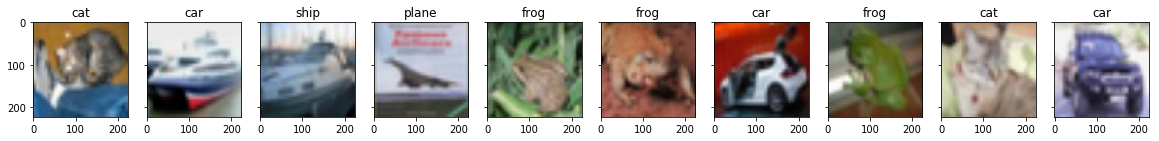

In [21]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

n_images = 10

fig, axes = plt.subplots(nrows=1, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]

for i in range(n_images):
    curr_img = orig_images[i].detach().to(torch.device('cpu'))
    curr_img = unnormalize(curr_img,
                           torch.tensor([0.485, 0.456, 0.406]),
                           torch.tensor([0.229, 0.224, 0.225])) 
    curr_img = curr_img.permute((1, 2, 0))
    axes[i].imshow(curr_img)
    axes[i].set_title(classes[predicted_labels[i]])